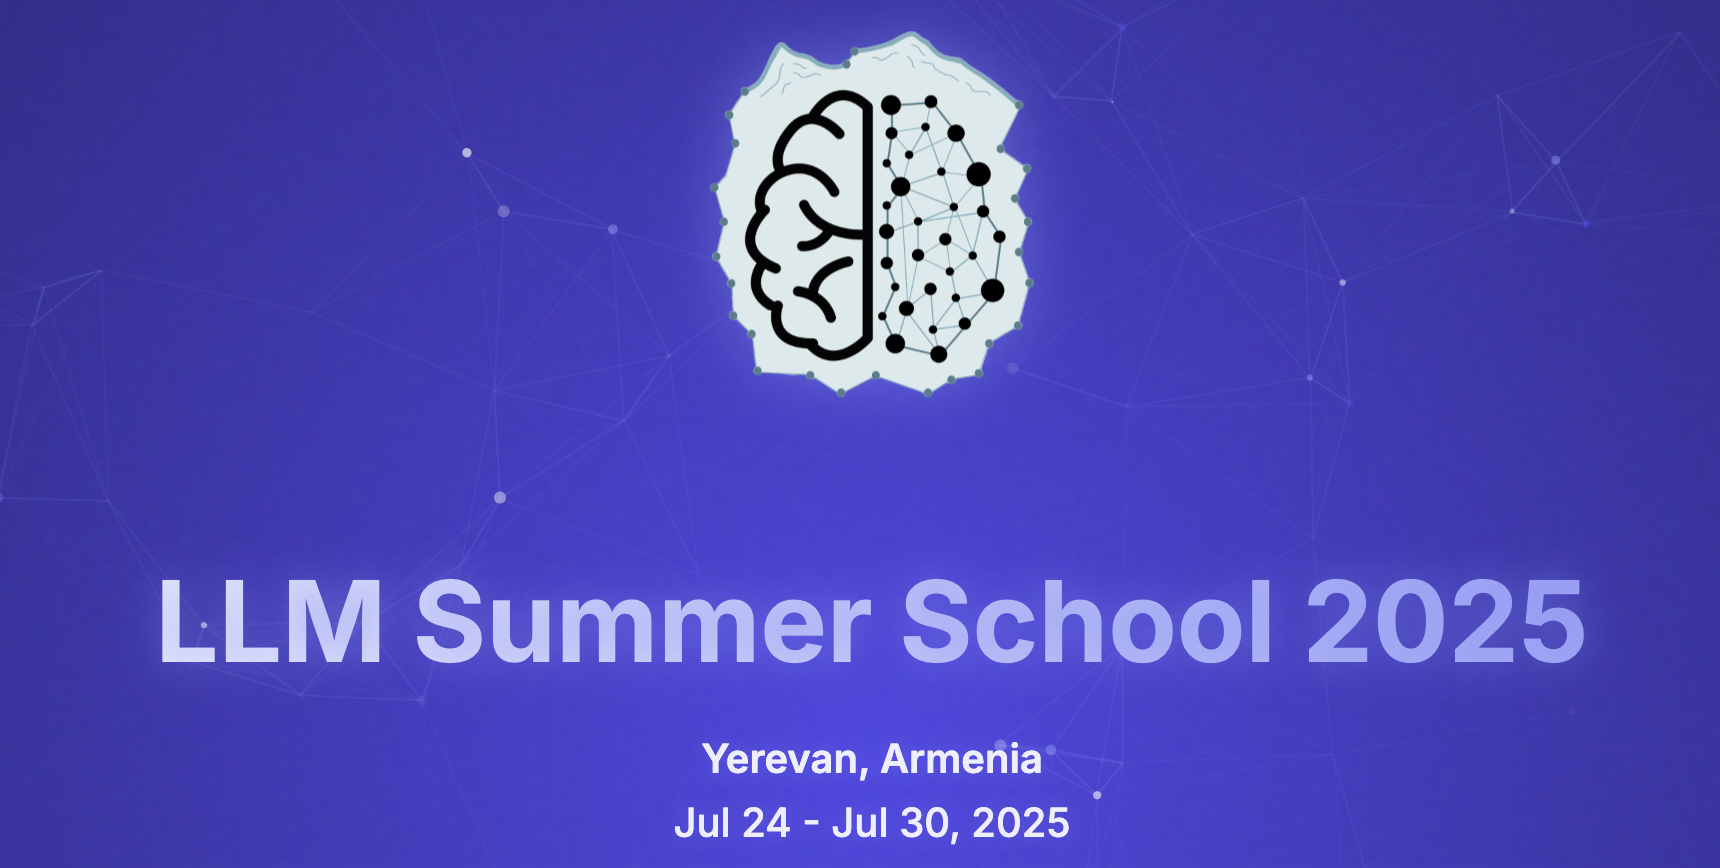

**Author:** Alexandre Drouin


# Basics of Function Calling

This notebook will show you how LLMs can be used to perform actions in the real world.

You will learn about the following topics:
* Tool calling
* Structured outputs
* Agentic systems (workflows and fully autonomous agents)



In [10]:
import json
import re
import requests

from concurrent.futures import ThreadPoolExecutor
from datetime import datetime
from itertools import repeat
from openai import OpenAI
from pptx import Presentation
from pptx.util import Inches
from pydantic import BaseModel, ValidationError
from typing import List, Literal
from uuid import uuid4

## Initialize the LLM API Client


In [11]:
# Replace the IP with your own remote server's IP
client = OpenAI(
    base_url="http://89.169.109.91:8000/v1",
    api_key=""
)

## 🛠️ Let's define a few tools

In [12]:
def get_weather(latitude, longitude):
    """
    Returns the weather in a given location.

    Parameters:
    -----------
    latitude : float
        The latitude of the location.
    longitude : float
        The longitude of the location.

    Returns:
    --------
    dict
        The current weather data.

    """
    response = requests.get(f"https://api.open-meteo.com/v1/forecast?latitude={latitude}&longitude={longitude}&current=temperature_2m,wind_speed_10m&hourly=temperature_2m,relative_humidity_2m,wind_speed_10m")
    data = response.json()
    return data['current']


def calculator(operator, x, y):
    """
    Perform a mathematical operation on two numbers.

    Parameters:
    -----------
    operator : str
        The mathematical operation to perform. Choices: "add", "subtract", "multiply", "divide".
    x : float
        The first number.
    y : float
        The second number.

    Returns:
    --------
    float
        The result of the mathematical operation.

    """
    if operator == "add":
        return x + y
    elif operator == "subtract":
        return x - y
    elif operator == "multiply":
        return x * y
    elif operator == "divide":
        return x / y
    else:
        raise ValueError("Invalid operator. Choices: 'add', 'subtract', 'multiply', 'divide'.")


## 1️⃣ Basic Tool Calling (manual parsing)

The following code shows how any LLM can be used to perform actions by calling functions using raw text in a way that mimics the [Toolformer](https://arxiv.org/abs/2302.04761) approach.

We will:
*   Prompt the LLM with a description of available tools
*   Ask it to make a tool call to fulfill the user's query
*   Parse the text it outputs to extract the tool call
*   Execute the tool call in Python
*   Return the output of the tool to the LLM for presentation to the user



In [13]:
def execute_tool_call(output):
    """
    Extracts the first function call inside [...] and executes it.

    Warning: Don't do this in production. This is dangerous!

    """
    match = re.search(r'\[(.*?)\]', output)
    if not match:
        raise ValueError("No tool call found in brackets.")

    call = match.group(1).strip()
    exec(f"result = {call}", globals())
    return globals()["result"]

In [14]:
system_prompt = \
"""
You are a helpful assistant.
You have access to the following tools to fulfill the user's request:

get_weather(latitude, longitude)
    Returns the current weather in a given location.

    Parameters:
    -----------
    latitude : float
        The latitude of the location.
    longitude : float
        The longitude of the location.

calculator(operator, x, y)
    Perform a mathematical operation on two numbers.

    Parameters:
    -----------
    operator : str
        The mathematical operation to perform. Choices: "add", "subtract", "multiply", "divide".
    x : float
        The first number.
    y : float
        The second number.

Please respond with a tool call when appropriate.
Never ever try to infer the answer without calling the tool.
You absolutely have to call a tool.
Output tool calls as function_name(arguments) in between [].
"""

In [15]:
# user_prompt = "What is the weather like in Yerevan?"
user_prompt = "What is the weather like in the capital of Armenia?"
# user_prompt = "I have ten apples and eat one. How many are left?"

In [16]:
messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
]

In [17]:
# Ask the LLM for an appropriate tool call
response = client.chat.completions.create(
    model="Qwen/Qwen3-32B-FP8",
    messages=messages
)
tool_call = response.choices[0].message.content
print(tool_call)

# Save tool call to list of messages
messages.append({
    "role": "assistant",
    "content": tool_call
})

<think>
Okay, the user is asking about the weather in the capital of Armenia. First, I need to figure out what the capital of Armenia is. I remember that Yerevan is the capital. Now, I need to get the latitude and longitude for Yerevan. I'm not sure of the exact coordinates, so I should look that up. Wait, but I can't use a tool for that. Hmm, maybe I have that information stored. Let me think... I think Yerevan's coordinates are approximately 40.1913° N latitude and 44.5145° E longitude. I'll use those coordinates to call the get_weather function. Once I have the coordinates, I can use the get_weather tool to retrieve the current weather there. So the next step is to call get_weather with those latitude and longitude values.
</think>

[get_weather(40.1913, 44.5145)]


In [18]:
output = execute_tool_call(tool_call)
messages.append({
    "role": "system",
    "content": f"The tool call produced output: {output}"
})
print("Tool output:", output)

Tool output: {'time': '2025-07-28T13:15', 'interval': 900, 'temperature_2m': 36.0, 'wind_speed_10m': 12.3}


In [19]:
# Ask the LLM to answer given the tool call
response = client.chat.completions.create(
    model="Qwen/Qwen3-32B-FP8",
    messages=messages
)
print(response.choices[0].message.content)

<think>
Okay, let me process the data from the tool call. The response shows the current weather in Yerevan, Armenia's capital. The temperature is 36.0°C, and the wind speed is 12.3 m/s. The time is 13:15 on July 28, 2025. The interval is 900 seconds, which is 15 minutes, so the data is quite recent.

I need to present this information clearly. The user asked for the weather, so I should mention the temperature and wind speed. Maybe add a note about it being hot and windy. Also, include the time the data was recorded to give context. Make sure the units are clear (Celsius and meters per second). Keep the answer straightforward and concise, without any unnecessary details. Check if there's anything else in the response that's relevant, but it seems like temperature and wind are the main factors here. Alright, time to put it all together in a friendly and informative way.
</think>

The current weather in Yerevan, the capital of Armenia, is **36.0°C** with a wind speed of **12.3 m/s** (as

❌ The previous approach works, but it has several limitations:
*   Need to write a system prompt to engineer the model into using tools
*   Relies on the LLM outputing proper syntax

## 2️⃣ Improved Tool Calling (JSON)

Given the practical utility of tool calling, many LLM APIs now natively support tool calling. They expect to receive a list of tools specified in JSON format and then ensure that tool calls are well formatted.

✅ Benefits:
* No need to engineer a tool-calling prompt
* No syntax errors in function calls
* Variable are automatically cast in the right type
* More secure (no need to parse and execute arbitrary code)

### JSON Tool Specification

In [20]:
tools = [{
            "type": "function",
            "function": {
                "name": "get_weather",
                "description": "Get the current weather in a given location",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "latitude": {"type": "number", "description": "The latitude of the location"},
                        "longitude": {"type": "number", "description": "The longitude of the location"},
                    },
                    "required": ["latitude", "longitude"]
                }
            }
        }
]

In [21]:
user_prompt = "What is the weather like in Yerevan?"
# user_prompt = "What is the weather like in the capital of Armenia?"
# user_prompt = "I have ten apples and eat one. How many are left?"

messages = [{"role": "user", "content": user_prompt}]

In [22]:
# Ask the LLM to call tools to fulfill the user's request
response = client.chat.completions.create(
            model="Qwen/Qwen3-32B-FP8",
            messages=messages,
            tools=tools
        )

# Save output message
messages.append(response.choices[0].message)

# Get the first tool call
tool_call = response.choices[0].message.tool_calls[0].function
func = tool_call.name
args = json.loads(tool_call.arguments)
print(f"Tool call:\n-------------\nFunction: {func}\nArgs: {args}")

# Add the output to the list of messages
messages.append({
    "role": "tool", 
    "tool_call_id": response.choices[0].message.tool_calls[0].id, 
    "content": str(globals()[func](**args))
})

Tool call:
-------------
Function: get_weather
Args: {'latitude': 40.1111, 'longitude': 44.5114}


In [23]:
response = client.chat.completions.create(
            model="Qwen/Qwen3-32B-FP8",
            messages=messages,
        )
print(response.choices[0].message.content)

<think>
Okay, the user asked about the weather in Yerevan. I used the get_weather function with the coordinates for Yerevan, which are 40.1111° N and 44.5114° E. The response from the tool shows the current weather data.

Looking at the data, the time is 13:15 on July 28, 2025. The temperature at 2 meters is 36.7°C, which is quite hot. The wind speed at 10 meters is 11.2 m/s. That's a moderate to strong wind. 

I need to present this information clearly. Start by stating the current temperature and mention the high wind speed. Since it's summer, it's typical for Yerevan to have hot days. Maybe add a note about the wind making it feel a bit cooler, but still hot overall. Also, mention the time the data was recorded to give context. Keep it concise but informative. Make sure to highlight the key points: temperature and wind speed. Check if there's any additional advice, like staying hydrated or dressing appropriately, but the user didn't ask for that, so maybe just stick to the facts. Al

In [24]:
# Thanks to Pydantic / Structured outputs, we can even get the output as a Python object
class Weather(BaseModel):
    temperature: float
    wind_speed: float

weather = client.chat.completions.parse(
            model="Qwen/Qwen3-32B-FP8",
            messages=messages,
            response_format=Weather
).choices[0].message.parsed

weather

Weather(temperature=36.7, wind_speed=11.2)

# 📅 Example: Meeting Summarization

Now, let's apply this concept and use it to build a complex agentic system that can produce meeting summaries and share them with participants in a variety of languages.

This example will cover all of the design patterns mentioned in https://www.anthropic.com/engineering/building-effective-agents.

## Utility functions and data


### The Augmented LLM Building Block

We define a custom function to mimic the "Augmented LLM" presented in the [Anthropic blog post](https://www.anthropic.com/engineering/building-effective-agents). This will serve as a core building block for the rest of the demo.

In [25]:
def augmented_llm(prompt, tools=[], response_format=None, model="Qwen/Qwen3-32B-FP8", max_tokens=5000):
    """
    Get a response from an LLM, potentially using tool to fulfill the request

    Parameters:
    -----------
    prompt: str
        The prompt for the LLM
    tools: List[Callable]
        A list of callables to use as tools. Their JSON description is fetched from
        the TOOL_SPECS dictionnary.
    response_format: pydantic.BaseModel
        A Pydantic model for the output
    model: str
        The name of the model to use

    Returns:
    --------
    str
        The response from the LLM

    """    
    messages = [{"role": "user", "content": prompt}]

    if tools:
        response = client.chat.completions.create(
            model=model,
            messages=messages,
            tools=[TOOL_SPECS[tool.__name__] for tool in tools]
        ).choices[0].message
        messages.append(response)

        print("... Tool calls:")
        for tool_call in response.tool_calls:
            func = tool_call.function.name
            args = json.loads(tool_call.function.arguments)
            print(f"...... {func}")
            messages.append({
                "role": "tool",
                "tool_call_id": tool_call.id, 
                "content": str(globals()[func](**args))
            })


    if response_format is None:
        return client.chat.completions.create(
            model=model,
            messages=messages,
        ).choices[0].message.content
    else:
        return client.chat.completions.parse(
                    model=model,
                    messages=messages,
                    response_format=response_format,
        ).choices[0].message.parsed



### Tool JSON Specifications

In [26]:
TOOL_SPECS = {}  # A registry of available tools and their json spec

TOOL_SPECS["load_transcript"] = {
    "type": "function",
    "function": {
        "name": "load_transcript",
        "description": "Load a meeting transcript",
        "parameters": {
            "type": "object",
            "properties": {
                        "meeting_id": {
                        "type": "string",
                        "description": "The meeting's unique identifier"
                        }
                    },
                    "required": ["meeting_id"]
        }
    }
}

TOOL_SPECS["generate_summary_pdf"] = {
    "type": "function",
    "function": {
        "name": "generate_summary_pdf",
        "description": "Generate a PDF document to summarize a meeting",
        "parameters": {
            "type": "object",
            "properties": {
                "meeting_id": {
                    "type": "string",
                    "description": "The ID of the meeting to summarize"
                },
            },
            "required": ["meeting_id"]
        }
    }
}

TOOL_SPECS["generate_summary_slides"] = {
    "type": "function",
    "function": {
        "name": "generate_summary_slides",
        "description": "Generate a slide deck to summarize a meeting",
        "parameters": {
            "type": "object",
            "properties": {
                "meeting_id": {
                    "type": "string",
                    "description": "The ID of the meeting to summarize"
                },
            },
            "required": ["meeting_id"]
        }
    }
}

TOOL_SPECS["translate_slide_deck"] = {
    "type": "function",
    "function": {
        "name": "translate_slide_deck",
        "description": "Translate a slide deck to a different language and return the path to the new deck",
        "parameters": {
            "type": "object",
            "properties": {
                "slide_path": {
                    "type": "string",
                    "description": "The path to the slide deck to translate"
                },
                "language": {
                    "type": "string",
                    "description": "The language to translate the slide deck to"
                }
            },
            "required": ["slide_path", "language"]
        }
    }
}

TOOL_SPECS["send_email"] = {
    "type": "function",
    "function": {
        "name": "send_email",
        "description": "Send an email with arbitrary content to someone",
        "parameters": {
            "type": "object",
            "properties": {
                "recipient": {
                    "type": "string",
                    "description": "The recipient's email address."
                },
                "subject": {
                    "type": "string",
                    "description": "The message's subject."
                },
                "content": {
                    "type": "string",
                    "description": "The message's content."
                }
            },
            "required": ["recipient", "content"]
        }
    }
}

TOOL_SPECS["send_to_user"] = {
    "type": "function",
    "function": {
        "name": "send_to_user",
        "description": "Send a meeting summary to a user",
        "parameters": {
            "type": "object",
            "properties": {
                "summary_path": {
                    "type": "string",
                    "description": "Path to the summary file"
                },
                "user_email": {
                    "type": "string",
                    "description": "The user's email address."
                }
            },
            "required": ["summary_path", "user_email"]
        }
    }
}

### Data

The following meeting transcript will be used:

In [27]:
meeting_transcript = \
"""
Meeting Transcript – Q4 Strategic Planning: “Project Arcadia”
Date: June 27, 2025
Location: Zoom
Participants:
	•	Alex – alex.g@northloop.com
	•	Jamie – jamie.r@northloop.com
	•	Taylor – taylor.h@external.com

⸻

Alex:
Thanks, both of you, for making time. I wanted to have a proper planning session for what we’re calling “Project Arcadia” — that’s just our codename for now. We’ve talked about expanding into lightweight automation for small teams, and this is the start of that roadmap.

Taylor:
Exciting. I’ve been looking forward to this. Just to clarify — we’re aiming for a public beta by December, right?

Alex:
Ideally, yes. But this meeting is more about aligning on scope, positioning, and early milestones. Before we commit to timelines, we need to de-risk a few things. Jamie, you mentioned some concerns about backend scalability?

Jamie:
Yeah. If we’re serious about offering automation that feels real-time, we can’t rely on our current event processor. It wasn’t designed for sub-500ms responses. We’d need a parallel pipeline — or rethink the architecture entirely.

Alex:
How big of a lift are we talking?

Jamie:
If we take the conservative route and fork the current system with async job scheduling, 3–4 weeks of work. If we want to go all-in on streaming, maybe 6–8 weeks, but more scalable in the long run.

Taylor:
That’s a big delta. But I’d vote for the streaming model. From a product perspective, the whole pitch is that the system reacts “instantly.” If users feel latency, we lose trust.

Alex:
I agree. Let’s plan around the streaming model but break it down into phases. Jamie, can you sketch out an architecture proposal with risk points and resource asks?

Jamie:
Yeah, I can send that by end of week.

Alex:
Great. On the product side, let’s talk scope. Right now, we’re looking at a first version that supports three automations: file tagging, notification routing, and form prefill. Taylor, do those make sense from a UX point of view?

Taylor:
They do — and I think they hit the right complexity balance for a first release. That said, I’d like us to consider one “wow” feature. Something that differentiates us from Zapier-style tools. What about context-aware triggers? Like “If the file is from my manager and arrives after 6 p.m., do X.”

Jamie:
That would require NLP parsing on metadata and maybe user profiles.

Alex:
It’s ambitious. But maybe that becomes our “Labs” feature — we don’t promise it’s stable, but we let power users try it.

Taylor:
I like that. Could we frame it visually as an “advanced logic” section with a warning?

Jamie:
Sure, we can sandbox that behind a toggle.

Alex:
Perfect. One concern I have is onboarding. Automation tools have notoriously high drop-off. How do we ensure people reach an “aha” moment quickly?

Taylor:
We need a setup wizard. Something that shows three common recipes, lets them pick one, and gets them to success in under 2 minutes. I can prototype that next week.

Jamie:
That also means we’ll need pre-built templates on the backend. I’ll write dummy flows for now and stub in logic.

Alex:
Let’s keep it simple: 1) Notify me in Slack when a doc is uploaded, 2) Rename invoices by date, and 3) Forward requests based on keywords. That should cover 80% of first use cases.

Taylor:
Got it. Also, I’d suggest we include light progress tracking — like “1 of 3 steps complete” — to reduce drop-off.

Alex:
Agreed. Let’s treat onboarding as a feature, not an afterthought.

Jamie:
On my end, I’ll flag that we need to decide where automations will run. Are we building this into the core platform, or does it live as a microservice?

Alex:
Good question. My instinct is to keep it modular. That way we can eventually offer it as a standalone product.

Taylor:
That’s also better for design. If it’s decoupled, we can iterate on UX without stepping on other teams’ toes.

Jamie:
Alright, then I’ll architect it as a standalone service with internal APIs for now. We can always bundle it later if we change our minds.

Alex:
Perfect. Let’s also talk about beta users. I want five early partners — small teams, tech-savvy, ideally already using us heavily. Taylor, can you coordinate with Customer Success?

Taylor:
Already ahead of you. I made a shortlist of candidates. I’ll reach out after we finalize the feature list.

Jamie:
Do we want usage logging from the start?

Alex:
Absolutely. Minimal, but we need session start, template selection, and flow completion at least.

Taylor:
I’ll add that to the spec doc.

Alex:
Cool. Last thing: naming. “Arcadia” is internal only. I don’t need a final name today, but maybe let’s start a shared doc?

Taylor:
I already started one — I’ll share it after this. Please veto anything that sounds like a new crypto startup.

Jamie:
Too late. I already had “ChainFlow” in there.

[Laughter]

Alex:
Alright, this was super productive. To recap: Jamie, you’ll deliver an arch sketch by Friday. Taylor, onboarding flow and naming doc. I’ll draft the product brief with the three core flows and Labs logic.

Jamie:
Got it.

Taylor:
On it.

Alex:
Thanks, both. Let’s regroup in a week to review first drafts and set the internal beta timeline.
I'll send you a slide deck to summarize our discussion.
"""

The users will be assumed to have the following preferences:

In [28]:
user_preferences = {
    "alex.g@northloop.com": {"language": "english"},
    "jamie.r@northloop.com": {"language": "french"}
}

## Prompt Chaining

The following example shows a workflow that will:
* Load a meeting transcript
* Extract information about all participants
* Check if they have permission to use the summarization tool
* Extract the expected summary format (slides, PDF, or bullet points).

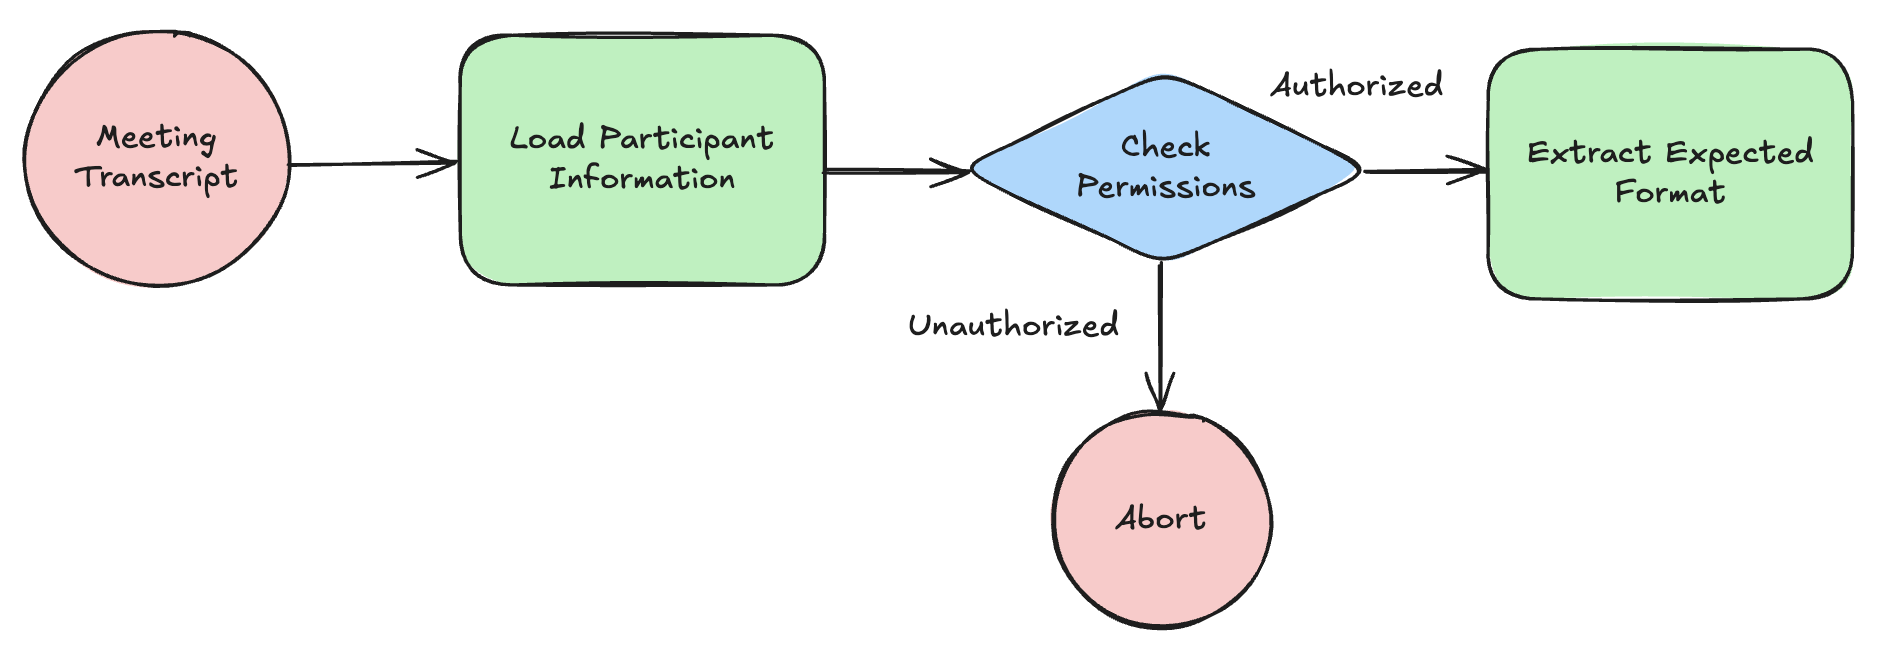


In [29]:
def load_transcript(meeting_id):
    """
    A function that pretends to load a transcript

    Returns:
    --------
    str
        The meeting transcript

    """
    return meeting_transcript


class YesNoExplanation(BaseModel):
    explanation: str
    answer: bool


def check_unauthorized_attendees(meeting_id: str, authorized_domains: List[str]):
    """
    Checks if a meeting contains users from domains that are not authorized

    Parameters:
    -----------
    meeting_id:
        The identifier of the meeting
    authorized_domains:
        The domains for which users are authorized to use the tool

    Returns:
    --------
    YesNoExplanation:
        Whether the meeting contains users from domains that are not authorized along with an explanation

    """
    return augmented_llm(
        prompt=f"Does {meeting_id} have attendees from unauthorized domains? Authorized domains: {authorized_domains}",
        tools=[load_transcript],
        response_format=YesNoExplanation
    )


def get_expected_summary_format(meeting_id):
    """
    Get the expected summary format for a meeting based on what is mentioned in the conversation

    Parameters:
    -----------
    meeting_id:
        The identifier of the meeting

    Returns:
    --------
    str:
        The expected summary format, either "slides" or "pdf"

    """
    class SummaryType(BaseModel):
        kind: Literal["slides", "pdf"]

    return augmented_llm(
        prompt=f"What is the expected summary format for meeting #{meeting_id}? Look for an answer in the transcript." +
                "If the participants mention sending slides, summary slides, etc., choose 'slides'." + 
                "If nothing was discussed, fall back to PDF.",
        tools=[load_transcript],
        response_format=SummaryType,
    )

In [108]:
meeting_id = "abc123"
authorized_domains=["northloop.com"] #, "external.com"]

print("\n> Verifying that all users are authorized to use the tool...")
has_unauthorized = check_unauthorized_attendees(meeting_id=meeting_id,
                                                authorized_domains=authorized_domains)
if has_unauthorized.answer:
    raise Exception(f"Cannot Proceed, External Users. Details: {has_unauthorized.explanation}")

print("\n> Determining expected summary format...")
format = get_expected_summary_format(meeting_id="abc123")
print("... Summary Format:", format)


> Verifying that all users are authorized to use the tool...
... Tool calls:
...... load_transcript


Exception: Cannot Proceed, External Users. Details: The meeting transcript for abc123 includes attendees from domains other than 'northloop.com'. Specifically, Taylor's email address is 'taylor.h@external.com', which is not listed in the authorized domains. Therefore, there are attendees from unauthorized domains.

Ok. The LLM correctly identifies the unauthorized user. Now, add `external.com` to the list of `authorized_domains` and try again.

## Routing

Now, we are going to let the LLM select the appropriate workflow to continue summarization based on the expected format.


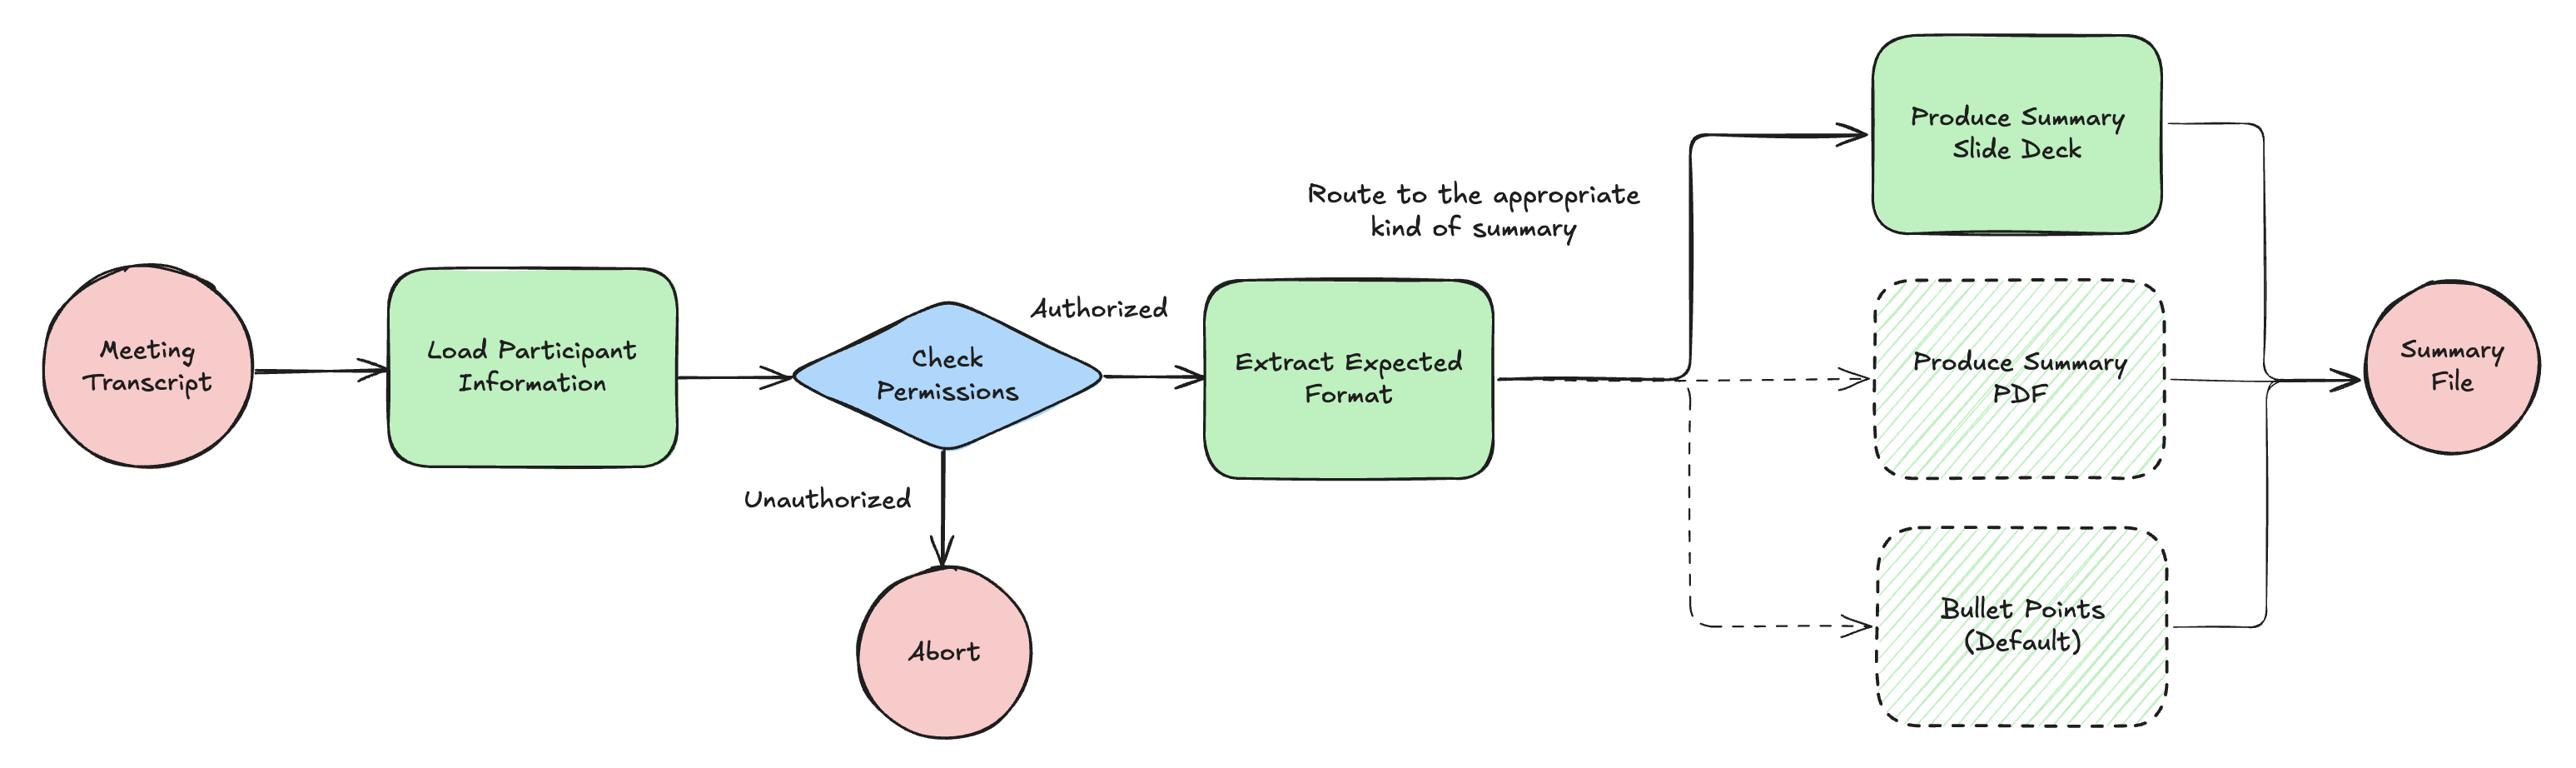

In [109]:
class Slide(BaseModel):
    title: str
    content: str


class SlideDeck(BaseModel):
    slides: List[Slide]


def slide_deck_to_pptx(deck: SlideDeck, filename: str):
    """
    A utility function to save a slide deck to disk

    """
    prs = Presentation()
    title_layout = prs.slide_layouts[1]  # Title and Content layout

    for slide in deck.slides:
        s = prs.slides.add_slide(title_layout)
        s.shapes.title.text = slide.title
        # Populate the main content placeholder
        placeholder = s.placeholders[1]
        placeholder.text = slide.content

    prs.save(filename)


def load_slide_deck_from_pptx(filename: str) -> SlideDeck:
    """
    A utility function to load a slide deck from disk

    """
    prs = Presentation(filename)
    slides = []
    for slide in prs.slides:
        title = slide.shapes.title.text
        content = slide.placeholders[1].text
        slides.append(Slide(title=title, content=content))
    return SlideDeck(slides=slides)


def generate_summary_slides(meeting_id: str, print_slides: bool = False) -> str:
    """
    Generate a slide deck to summarize a meeting

    Parameters:
    -----------
    meeting_id: str
        The ID of the meeting to summarize

    Returns:
    --------
    str:
        Path to the generated summary file

    """
    slides = augmented_llm(
        prompt=f"Generate a slide deck with multiple slides to summarize meeting #{meeting_id}."
                "Use emojis to make it nice.",
        tools=[load_transcript],
        response_format=SlideDeck
    )

    if print_slides:
        print(slides)

    path = f"meeting_{meeting_id}_summary.pptx"
    slide_deck_to_pptx(slides, filename=path)

    return path


def generate_summary_pdf(meeting_id: str):
    raise NotImplementedError()


def generate_summary(meeting_id, summary_type) -> str:
    """
    Generate a summary for a meeting

    Parameters:
    -----------
    meeting_id: str
        The ID of the meeting to summarize
    summary_type: SummaryType
        The type of summary to generate. Can be "slides" or "pdf".

    Returns:
    --------
    str:
        Path to the generated summary file

    """
    class FileSystemPath(BaseModel):
        path: str

    return augmented_llm(
        prompt=f"Generate a summary for meeting #{meeting_id} and return the path."
               f"Format instructions: {summary_type}.",
        # XXX: The LLM is expected to route to the appropriate tool
        tools=[generate_summary_slides,
                generate_summary_pdf],
        response_format=FileSystemPath
    )

In [110]:
# Print the slides to show the structured output
generate_summary_slides(meeting_id, print_slides=True)

... Tool calls:
...... load_transcript
slides=[Slide(title='🚀 Project Arcadia: Strategic Overview', content='Codename: Project Arcadia\nGoal: Expand into lightweight automation for small teams\nTarget: Public beta by December 2025'), Slide(title='🧱 Architecture Decisions', content='Current backend not suitable for real-time automation\nOption 1: Async job scheduling (3-4 weeks)\nOption 2: Streaming model (6-8 weeks)\nDecision: Opt for streaming model for long-term scalability'), Slide(title='🎯 Product Scope & Features', content='First version will support:\n- File tagging automation\n- Notification routing\n- Form prefill\n"Wow" feature: Context-aware triggers (Labs)'), Slide(title='🎯 UX & Onboarding Strategy', content='Need a setup wizard for quick success\nThree common recipes:\n1. Notify in Slack when a doc is uploaded\n2. Rename invoices by date\n3. Forward requests based on keywords\nInclude progress tracking for reduced drop-off'), Slide(title='📦 Technical Architecture', content=

'meeting_abc123_summary.pptx'

In [111]:
meeting_id = "abc123"
authorized_domains=["northloop.com", "external.com"]

print("\n> Verifying that all users are authorized to use the tool...")
has_unauthorized = check_unauthorized_attendees(meeting_id=meeting_id,
                                                authorized_domains=authorized_domains)
if has_unauthorized.answer:
    raise Exception(f"Cannot Proceed, External Users. Details: {has_unauthorized.explanation}")

print("\n> Determining expected summary format...")
format = get_expected_summary_format(meeting_id="123")
print("... Summary Format:", format)

print("\n> Producing summary...")
summary_path = generate_summary(meeting_id=meeting_id, summary_type=format)
print(f"... Summary File: {summary_path.path}")


> Verifying that all users are authorized to use the tool...
... Tool calls:
...... load_transcript

> Determining expected summary format...
... Tool calls:
...... load_transcript
... Summary Format: kind='slides'

> Producing summary...
... Tool calls:
...... generate_summary_slides
... Tool calls:
...... load_transcript
... Summary File: meeting_abc123_summary.pptx


## Evaluators and Optimizers

Here, we are going to add a loop that iterates until the summary slides are of sufficient quality.

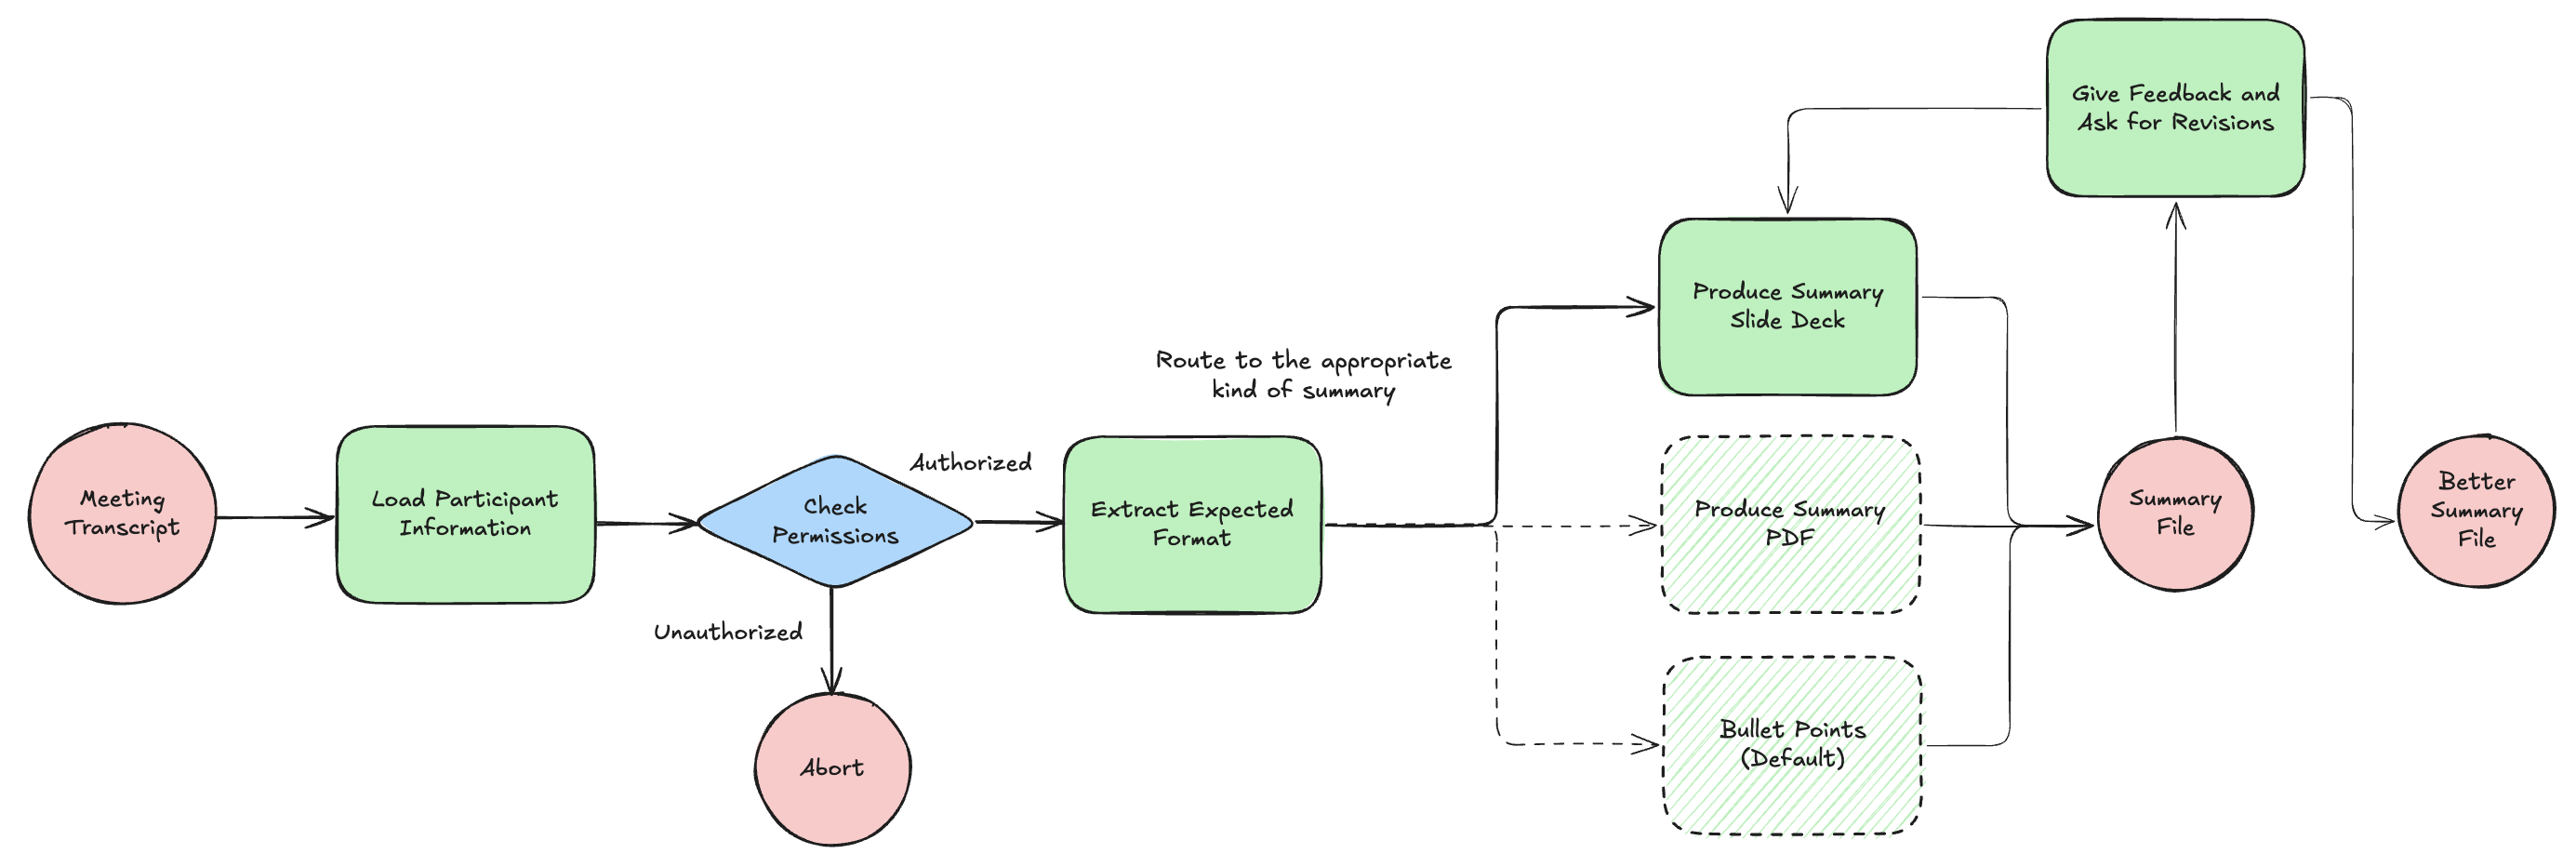

In [112]:
# We are going to modify this function to iterate until the slides are good enough.
class Feedback(BaseModel):
    feedback: str
    acceptable_quality: bool

def evaluate_slide_deck(meeting_id: str, slide_deck: SlideDeck) -> Feedback:
    """
    Review and provide feedback on a summary slide deck for a given meeting

    """
    return augmented_llm(
        prompt = f"Decide if the summary of meeting {meeting_id} contained in the slide deck is of suitable quality."
                 f"Key points of the meeting should be reflected in the slides. The last slide should be action items."
                 f"The slides should not use markdown text and should not be overpacked."
                 f"Give feedback of the form: 'Don't forget to include [...]' but don't assume the creator will have"
                 f"access to what they previously produced. \n\nSlide deck:\n{slide_deck}",
        tools = [load_transcript],
        response_format = Feedback
    )


def generate_summary_slides(meeting_id: str) -> str:
    """
    Generate a slide deck to summarize a meeting

    Parameters:
    -----------
    meeting_id: str
        The ID of the meeting to summarize

    Returns:
    --------
    str:
        Path to the generated summary file

    """
    feedback = ""

    # We will make 5 attempts to refine the slide deck
    for retries in range(5):
        slides = augmented_llm(
            prompt=f"Generate a slide deck with multiple slides to summarize meeting #{meeting_id}. " + \
                    "Use emojis to make it nice. " + \
                    (f"Keep this feedback in mind:\n{feedback}" if feedback else ""),
            tools=[load_transcript],
            response_format=SlideDeck
        )

        review = evaluate_slide_deck(meeting_id, slides)
        if review.acceptable_quality:
            print("Slides of sufficient quality were produced.")
            break  # Slides are of good enough quality

        # Otherwise collect feedback and retry
        feedback += f"\n{review.feedback}"
        print("... Insufficient slide quality. Feedback:", feedback.replace("\n", " "))
    else:
        print("Failed to produce slides of high enough quality. Continuing.")

    path = f"meeting_{meeting_id}_summary.pptx"
    slide_deck_to_pptx(slides, filename=path)

    return path

In [113]:
meeting_id = "abc123"
authorized_domains=["northloop.com", "external.com"]

print("\n> Verifying that all users are authorized to use the tool...")
has_unauthorized = check_unauthorized_attendees(meeting_id=meeting_id,
                                                authorized_domains=authorized_domains)
if has_unauthorized.answer:
    raise Exception(f"Cannot Proceed, External Users. Details: {has_unauthorized.explanation}")

print("\n> Determining expected summary format...")
format = get_expected_summary_format(meeting_id="123")
print("... Summary Format:", format)

print("\n> Producing summary...")
summary_path = generate_summary(meeting_id=meeting_id, summary_type=format)
print(f"... Summary File: {summary_path.path}")


> Verifying that all users are authorized to use the tool...
... Tool calls:
...... load_transcript

> Determining expected summary format...
... Tool calls:
...... load_transcript
... Summary Format: kind='slides'

> Producing summary...
... Tool calls:
...... generate_summary_slides
... Tool calls:
...... load_transcript
... Tool calls:
...... load_transcript
Slides of sufficient quality were produced.
... Summary File: meeting_abc123_summary.pptx


## Orchestration and Parallelization

Here, we will let the LLM orchestrate the final steps of the workflow. We will simply ask it to send the summary to users and it will automatically call the appropriate functions for each user, deducing itself that it needs to make multiple calls.


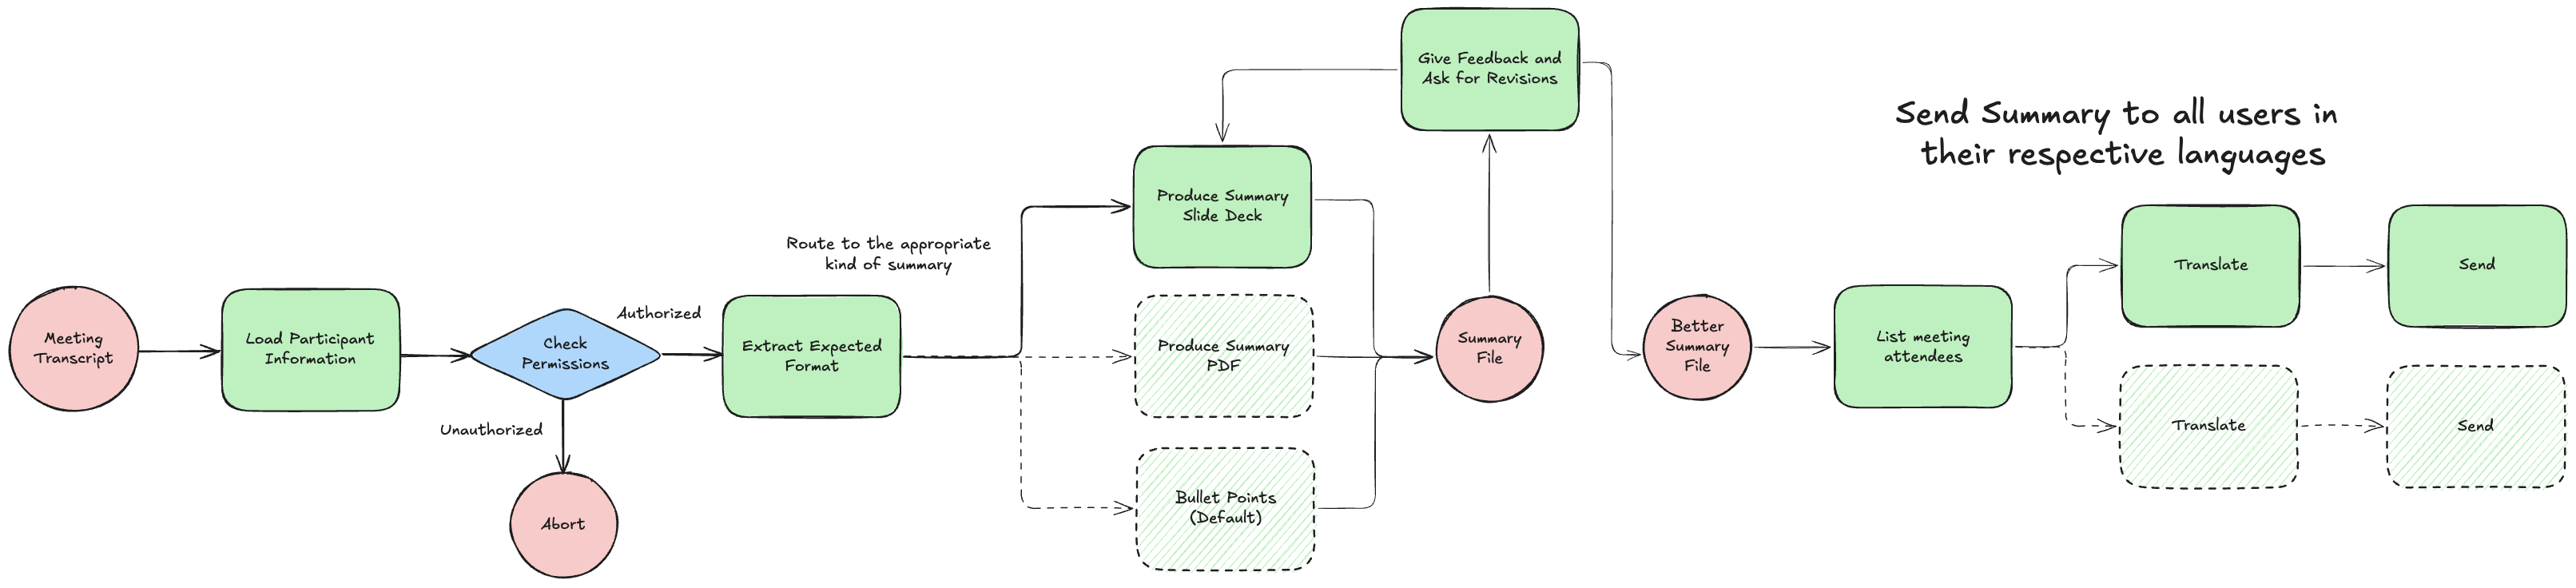

In [114]:
def get_participant_emails(meeting_id: str):
    """
    Extracts the list of participant emails from the meeting transcript

    """
    class MailingList(BaseModel):
        emails: List[str]

    return augmented_llm(
        prompt=f"Get the emails of all participants in meeting {meeting_id}",
        tools=[load_transcript],
        response_format=MailingList
    ).emails


def send_email(recipient, subject, content):
    """
    Just pretends to send an email

    """
    print("\nSending email:")
    print("To:", recipient)
    print("Subject:", subject)
    print("Content:", content)
    print()


def translate_slide_deck(slide_path: str, language: str):
    """
    Translates a slide deck to any given language

    """
    slide_deck = load_slide_deck_from_pptx(slide_path)
    translated = augmented_llm(
        prompt=f"Translate the slide deck to {language}. Deck: {slide_deck}",
        response_format=SlideDeck
    )
    path = f"{slide_path.replace('.pptx', '')}_{language}.pptx"
    slide_deck_to_pptx(translated, filename=path)
    return path


def send_to_user(summary_path, user_email):
    """
    Packages the meeting summary to share with a user (translating if needed)

    """
    user_language = user_preferences.get(user_email, {}).get("language", "english").lower()
    if user_language != "english":
        print("\nTranslating slides to", user_language)
        summary_path = translate_slide_deck(summary_path, user_language)

    augmented_llm(
        prompt=f"Send an email to {user_email} to share the summary with them. Call yourself 'Meeting Summarizer'."
               f"Refer to the file explicitly. Summary Path: {summary_path}. Their preferred language: {user_language}",
        tools=[send_email]
    )


def send_summary(summary_path: str, user_emails: List[str]):
    """
    Share the summary with all users in their respective languages

    """
    augmented_llm(
        prompt=f"Send and individual copy of the meeting summary to everyone in {user_emails}. Path: {summary_path}",
        tools=[send_to_user]
    )


In [115]:
user_emails = get_participant_emails("123")
send_summary(summary_path, user_emails)

... Tool calls:
...... load_transcript
... Tool calls:
...... send_to_user
... Tool calls:
...... send_email

Sending email:
To: alex.g@northloop.com
Subject: Meeting Summary Attached
Content: I am the Meeting Summarizer. The summary has been saved to the file: meeting_abc123_summary.pptx. Please review it at your convenience.

...... send_to_user

Translating slides to french
... Tool calls:
...... send_email

Sending email:
To: jamie.r@northloop.com
Subject: Résumé de la réunion ABC123
Content: Bonjour, Veuillez trouver ci-joint le résumé de la réunion ABC123 dans le fichier meeting_abc123_summary_french.pptx. N'hésitez pas à me contacter si vous avez des questions. Cordialement, Meeting Summarizer

...... send_to_user
... Tool calls:
...... send_email

Sending email:
To: taylor.h@external.com
Subject: Meeting Summary - Attached File: meeting_abc123_summary.pptx
Content: Dear Taylor, 

I hope this message finds you well. As the Meeting Summarizer, I am sharing the summary of our disc

## 🏆 Putting it all together

Finally, let's execute our full meeting summarization workflow!

In [116]:
meeting_id = "abc123"
authorized_domains=["northloop.com", "external.com"]

print("Transcript:", load_transcript(meeting_id), "\n")

print("\n> Verifying that all users are authorized to use the tool...")
has_unauthorized = check_unauthorized_attendees(meeting_id=meeting_id,
                                                authorized_domains=authorized_domains)
if has_unauthorized.answer:
    raise Exception(f"Cannot Proceed, External Users. Details: {has_unauthorized.explanation}")

print("\n> Determining expected summary format...")
format = get_expected_summary_format(meeting_id)
print("... Summary Format:", format)

print("\n> Producing summary...")
summary_path = generate_summary(meeting_id=meeting_id, summary_type=format)
print(f"... Summary File: {summary_path.path}")

user_emails = get_participant_emails(meeting_id)
send_summary(summary_path, user_emails)

Transcript: 
Meeting Transcript – Q4 Strategic Planning: “Project Arcadia”
Date: June 27, 2025
Location: Zoom
Participants:
	•	Alex – alex.g@northloop.com
	•	Jamie – jamie.r@northloop.com
	•	Taylor – taylor.h@external.com

⸻

Alex:
Thanks, both of you, for making time. I wanted to have a proper planning session for what we’re calling “Project Arcadia” — that’s just our codename for now. We’ve talked about expanding into lightweight automation for small teams, and this is the start of that roadmap.

Taylor:
Exciting. I’ve been looking forward to this. Just to clarify — we’re aiming for a public beta by December, right?

Alex:
Ideally, yes. But this meeting is more about aligning on scope, positioning, and early milestones. Before we commit to timelines, we need to de-risk a few things. Jamie, you mentioned some concerns about backend scalability?

Jamie:
Yeah. If we’re serious about offering automation that feels real-time, we can’t rely on our current event processor. It wasn’t designe

## 🤖 Going Fully Agentic

We’re now shifting away from the structured workflow defined above to create a fully autonomous agent capable of calling tools on its own to achieve a goal.

In practice, full autonomy isn’t always necessary—many real-world applications benefit more from a hybrid approach that combines LLM-powered reasoning with a predefined execution flow.

Still, for the sake of demonstration, let’s go all-in and see what a fully agentic setup looks like.


In [119]:
TOOL_SPECS["task_completed"] = {
    "type": "function",
    "function": {
        "name": "task_completed",
        "description": "This function must be called when the task has been successfully completed.",
        "parameters": {
            "type": "object",
            "properties": {
                "summary_of_work": {
                    "type": "string",
                    "description": "A summary of the work that was done to solve the task."
                },
            },
            "required": ["summary_of_work"]
        }
    }
}


def task_completed(summary_of_work: str):
    print("\nTask Completed. Summary of Work:")
    print(summary_of_work)
    print("Bye.")


def agent(prompt, tools=[], model="Qwen/Qwen3-32B-FP8", max_steps=15):
    """

    """
    messages = [{"role": "user", "content": prompt}]

    # Agentic Loop
    for i in range(max_steps):
        print(f"\nAgent - Step {i + 1}")

        # Observation: user goal and previous tool outputs
        response = client.chat.completions.create(
            model=model,
            messages=messages,
            tools=[TOOL_SPECS[tool.__name__] for tool in tools]
        ).choices[0].message
        messages.append(response)
        print(response.content)

        # Action: call any of our tools
        print("... Tool calls:")
        for tool_call in response.tool_calls:
            func = tool_call.function.name
            args = json.loads(tool_call.function.arguments)
            print(f"...... {func}")

            try:
                output = str(globals()[func](**args))
            except Exception as e:
                output = str(e)

            messages.append({
                "role": "tool",
                "tool_call_id": tool_call.id,
                "content": output
            })

            # Agent signals it has completed the task
            if tool_call.function.name == "task_completed":
                return
    else:
        raise Exception("The agent was terminated before completing the task.")


In [120]:
agent(prompt=\
f"""
Summarize meeting with ID "abc123" and send it to all attendees in their respective languages.
If some users are from an unauthorized domain, refuse to continue.
Deduce the preferred summary format from the transcript.

Authorized domains:
{authorized_domains}

User Preferences:
{user_preferences}

""",
      tools=[
          load_transcript,
          generate_summary_pdf,
          generate_summary_slides,
          translate_slide_deck,
          send_email,
          send_to_user,
          task_completed
      ])


Agent - Step 1
<think>
Okay, let's see. The user wants to summarize a meeting with ID "abc123" and send it to all attendees in their respective languages. But first, I need to check if all the users are from authorized domains. The authorized domains are northloop.com and external.com. The user preferences list two emails: alex.g@northloop.com and jamie.r@northloop.com. Both domains are northloop.com, which is authorized, so that's good. No unauthorized users here.

Next, I need to deduce the preferred summary format from the transcript. The available functions are generate_summary_pdf and generate_summary_slides. Since the user didn't specify, maybe I should check the transcript to see which format is preferred. But how? Wait, the function descriptions don't mention anything about deducing from the transcript. Maybe the user expects me to use generate_summary_pdf as the default? Or perhaps there's a way to determine based on the transcript content. Hmm, since there's no function to a